<center> <h1>mIA-X 8ª Edición</h1> </center>

<center> <h1>Práctica 9 - Modelos Generativos</h1> </center>

<center> <h1>Javier Langeber Gavilán</h1> </center>

<center> <h1>Ejercicio 5</h1> </center>

---

## Haz un modelo generativo condicional (GAN) sobre FashionMNIST usando sus etiquetas como condicionante. Explica las decisiones razonadamente

### 1. Carga de librerías

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import keras as tf
from keras.datasets import fashion_mnist
from keras.models import Model, load_model # for assembling a Neural Network model
from keras.layers import Input, Dense, Embedding, Reshape, Concatenate, Flatten, Dropout # for adding layers
from keras.layers import Conv2D, Conv2DTranspose, MaxPool2D, ReLU, LeakyReLU # for adding layers
from keras.utils import plot_model # for plotting model diagram
from keras.optimizers import Adam # for model optimization 

### 2. Obtención y preparación de datos

Como se ha hecho en ejercicios anteriores, en primer lugar, se obtienen y preparan los datos.

In [2]:
(x_train_or, y_train), (x_test_or, y_test) = fashion_mnist.load_data()
x_train = ((x_train_or / 255) - 0.5) * 2
x_test = ((x_test_or / 255) - 0.5) * 2

In [3]:
plt.set_cmap("gray")

<Figure size 640x480 with 0 Axes>

Se visualizan algunos datos para comprobar sus valores.

(-0.5, 27.5, 27.5, -0.5)

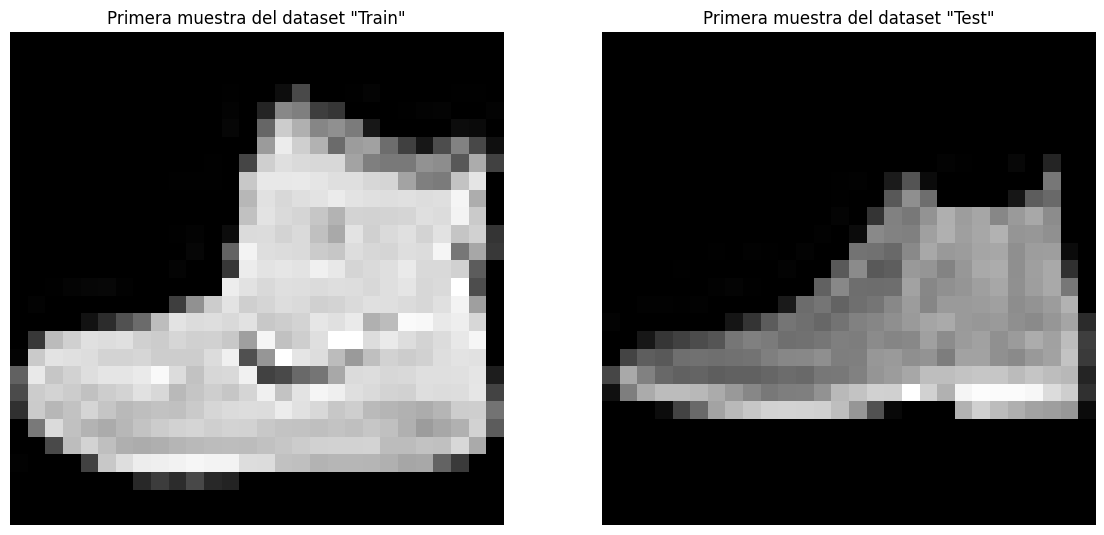

In [4]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize = (14,7))
ax1.imshow(x_train[0])
ax1.title.set_text('Primera muestra del dataset "Train"')
ax1.axis('off')
ax2.imshow(x_test[0])
ax2.title.set_text('Primera muestra del dataset "Test"')
ax2.axis('off')

### 3. Definición de la GAN

Una GAN (Generative Adversarial Network) es una red generativa que funciona enfrentando a 2 NN entre sí. Una red (la red generativa) tratará de generar nuevas muestras a partir de los datos de entrenamiento, y otra red (la red discriminatoria) tratará de estimar qué muestras son reales, y cuáles han sido creadas por la red generativa.

Adicionalmente, una GAN condicional tiene la capacidad de generar nuevas muestras específicamente sobre un tipo de dato en concreto. Es decir, en el caso del dataset fashion mnist, una GAN condicional es capaz de generar nuevas muestras sobre un tipo de datos concreto, a especificar por el usuario, como zapatos, o vestidos.

Con todo ello, los pasos para crear una GAN condicional son:

1. Crear la red generadora
2. Crear la red discriminatoria

#### 3.1. Red generadora

Una de las principales diferencias de una GAN con una GAN condicional, es que en la GAN condicional el generador debe tener en cuenta la etiqueta asociada al dato que se desea generar como un input más de la red.

In [9]:
def generator(latent_dim = 100, in_shape = (7,7,1), n_cats = 10):

    # En primer lugar, se realiza la parte del genearador asociada a las etiquetas de entrada

    # Input de etiqueta
    in_label = Input(shape=(1,), name='Generator-Label-Input')
    lbls = Embedding(n_cats, 30, name='Generator-Embedding-Label-Input')(in_label) # Se genera un embedding para las estiquetas
    
    # Escalado de dimensiones de la etiqueta de entrada
    n_nodes = in_shape[0] * in_shape[1] 
    lbls = Dense(n_nodes, name='Dense-Layer-Labels')(lbls)
    lbls = Reshape((in_shape[0], in_shape[1], 1), name='Reshape-Dense-Layer-Labels')(lbls)


    # -------------------------------------------------------------------------

    # A continuación, se realiza la parte del generador asociada a la creación
    # de nuevas muestras

    # Input de dimensiones latentes al generador
    in_latent = Input(shape=latent_dim, name='Latent-Input-Generator')
    
    # Generación de imágenes
    n_nodes = 128 * 7 * 7 
    g = Dense(n_nodes, name='Image-Generator-Layer')(in_latent)
    g = ReLU(name='Image-Genrator-Activation')(g)
    g = Reshape((in_shape[0], in_shape[1], 128), name='Image-Generator-Reshape')(g)


    # -------------------------------------------------------------------------
    # El generador debe unir la información proporcionada por la etiqueta, y la
    # generación de nuevas imágenes aleatorias, para ser capaz de generar nuevas
    # muestras asociadas a etiquetas concretas


    # Combinación de ambas partes y unión con capas ocultas
    concat = Concatenate(name='Generator-combination')([g, lbls])
    g = Conv2DTranspose(filters=128, kernel_size=(4,4), strides=(2,2), padding='same', name='Generator-Hidden-Layer-1')(concat)
    g = ReLU(name='Generator-Hidden-Layer-Activation-1')(g)
    g = Conv2DTranspose(filters=128, kernel_size=(4,4), strides=(2,2), padding='same', name='Generator-Hidden-Layer-2')(g)
    g = ReLU(name='Generator-Hidden-Layer-Activation-2')(g)
    
    # Capa de salida (activación "tanh" para asegurar valores entre -1 y 1)
    output_layer = Conv2D(filters=1, kernel_size=(7,7), activation='tanh', padding='same', name='Generator-Output-Layer')(g)
    
    # Por último, se genera el modelo con las capas definidas
    model = Model([in_latent, in_label], output_layer, name='Generator')
    return model

# Instanciación del generador
latent_dim=100 # Al igual que en ejericios anteriores, se ha decidido que el 
# espacio latente tenga 100 dimensiones. En verdad no serái necesario poner ese
# dato como input, puesto que ya se ha determinado como valor por defecto cuando
# se ha definido el generador.

gen_model = generator(latent_dim)

gen_model.summary()

Model: "Generator"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Latent-Input-Generator (InputL  [(None, 100)]       0           []                               
 ayer)                                                                                            
                                                                                                  
 Generator-Label-Input (InputLa  [(None, 1)]         0           []                               
 yer)                                                                                             
                                                                                                  
 Image-Generator-Layer (Dense)  (None, 6272)         633472      ['Latent-Input-Generator[0][0]'] 
                                                                                          

#### 3.2. Red discriminadora

La otra parte principal de una GAN es el discriminador. El discriminador es una NN a la que le entran imágenes, y debe ser capaz de discriminar aquellas reales de aquellas que han sido generadas artificialmente.

In [14]:
def discriminator(in_shape=(28,28,1), n_cats=10):
    
    # Del mismo modo que en el generador, en el discriminador también existen 2 
    # inputs, uno asociado a la imágen que debe ser discriminada, y otro asociado
    # a la etiqueta de esa imagen. Por ello, el discriminador también presenta 
    # estos 2 tipos de inputs (y al igual que en el generador, también se crea
    # un embedding para las etiquetas)

    # Inputs de etiquetas
    in_label = Input(shape=(1,), name='Discriminator-Label-Input')
    lbls = Embedding(n_cats, 50, name='Discriminator-Label-Embedding')(in_label)
    
    # Escalado de dimensiones de la etiqueta de entrada
    n_nodes = in_shape[0] * in_shape[1] 
    lbls = Dense(n_nodes, name='Discriminator-Label-Dense-Layer')(lbls)
    lbls = Reshape((in_shape[0], in_shape[1], 1), name='Discriminator-Label-Reshape-Layer')(lbls)

    # -------------------------------------------------------------------------

    # A continuación, se realiza la parte del discriminador asociada a la diferenciación
    # de imágenes

    # Input de dimensiones reales (28x28) al discriminador
    in_image = Input(shape=in_shape, name='Discriminator-Image-Input')

    # -------------------------------------------------------------------------
    # El discriminador debe unir la información proporcionada por la etiqueta, y la
    # capacidad de diferenciación de imágenes
    
    # Combinación de información y unión con capas ocultas
    concat = Concatenate(name='Discriminator-Combination')([in_image, lbls])
    h = Conv2D(filters=64, kernel_size=(3,3), strides=(2,2), padding='same', name='Discriminator-HL-1')(concat)
    h = LeakyReLU(alpha=0.2, name='Discriminator-Activation-HL-1')(h)
    h = Conv2D(filters=128, kernel_size=(3,3), strides=(2,2), padding='same', name='Discriminator-HL-2')(h)
    h = LeakyReLU(alpha=0.2, name='Discriminator-Activation-HL-2')(h)
    h = MaxPool2D(pool_size=(3,3), strides=(2,2), padding='valid', name='Discriminator-Pooling')(h)
    
    # Por último, es necesario "flattenear" la información proporcionada por las
    # capas convolucionales, y se añade una capa densa.
    h = Flatten(name='Discriminator-Flatten')(h) # Flatten the shape
    h = Dropout(0.2, name='Discriminator-Dropout')(h) # Randomly drop some connections for better generalization
   
    output_layer = Dense(1, activation='sigmoid', name='Discriminator-Output')(h) # Output Layer
    
    # Se crea el modelo con las capas definidas y se compila
    model = Model([in_image, in_label], output_layer, name='Discriminator')
    model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0002, beta_1=0.5), metrics=['accuracy'])
    return model

# Instanciación del modelo
dis_model = discriminator()
dis_model.summary()


Model: "Discriminator"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Discriminator-Label-Input (Inp  [(None, 1)]         0           []                               
 utLayer)                                                                                         
                                                                                                  
 Discriminator-Label-Embedding   (None, 1, 50)       500         ['Discriminator-Label-Input[0][0]
 (Embedding)                                                     ']                               
                                                                                                  
 Discriminator-Label-Dense-Laye  (None, 1, 784)      39984       ['Discriminator-Label-Embedding[0
 r (Dense)                                                       ][0]']               

#### 3.3. Definición de la GAN

Una vez se han configurado las 2 partes principales de una GAN (incluido el generdor con capacidad condicional), se puede crear la GAN

In [15]:
def def_gan(generator, discriminator):
    # Como se vio en la teoría, el primer paso es definir un modelo en el que 
    # el discriminador no sea entrenable, utilizando las entradas y salidas del
    # generador.
    discriminator.trainable = False
    gen_latent, gen_label = generator.input
    gen_output = generator.output
    
    gan_output = discriminator([gen_output, gen_label])
    
    model = Model([gen_latent, gen_label], gan_output, name="CGAN")
    
    model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0002, beta_1=0.5))
    return model

gan_model = def_gan(gen_model, dis_model)
gan_model.summary()


Model: "CGAN"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Latent-Input-Generator (InputL  [(None, 100)]       0           []                               
 ayer)                                                                                            
                                                                                                  
 Generator-Label-Input (InputLa  [(None, 1)]         0           []                               
 yer)                                                                                             
                                                                                                  
 Image-Generator-Layer (Dense)  (None, 6272)         633472      ['Latent-Input-Generator[0][0]'] 
                                                                                               

#### 3.4. Funciones auxiliares

##### 3.4.1. Funciones de tratamiento de muestras

Por último, se necesario definir una serie de funciones para hacer la distinción entre imágenes reales y falsas. Estas funciones permitirán entrenar el generador y el discriminador. Se crearán datos asociados a imágenes reales, con etiquetas verdaderas ("1"), y datos asociados a imágenes creadas por el generador, con etiquetas falsas ("0")

In [16]:
def real_samples(dataset, categories, n):
    indx = np.random.randint(0, dataset.shape[0], n) # Vector de imágenes aleatorias de longitud "n"   
    x, cat_labels = dataset[indx], categories[indx] # Selección de las imágenes reales
    y = np.ones((n, 1)) # Por último, se fuerza que las etiquetas sean "1" (son imágenes reales)
    return [x, cat_labels], y
    

# Es necesario definir una función que devuleva un vector de "z_dim" dimensiones
# asociado a una de las 10 etiquetas del dataset, para que se pueda generar una 
# nueva muestra a partir de ese vector latente, asociada a una categoría en concreto.
# Esta nueva muestra se asociará a una etiqueta de "0" (creada por el generador),
# y se pasará al discriminador
def latent_vector(latent_dim, n, n_cats=10):
    # Vector latente aleatorio
    latent_input = np.random.randn(latent_dim * n)
    latent_input = latent_input.reshape(n, latent_dim)
    # Etiqueta aleatoria
    cat_labels = np.random.randint(0, n_cats, n)
    return [latent_input, cat_labels] 
  

# Por último, es necesario entrenar al discriminador a distinguir imágenes falsas.
# Para ello, se crean imágenes con el generador, y se le asignan etiquetas de "0",
# para que el discriminador entienda que son falsas
def fake_samples(generator, latent_dim, n):
    # Generación de el vector latente y etiqueta aleatorios
    latent_output, cat_labels = latent_vector(latent_dim, n)
    # Generación de imágen aleatoria
    x = generator.predict([latent_output, cat_labels])
    # Asoiación de la nueva muestra a la etiqueta "0" (creado por el generador)
    y = np.zeros((n, 1))
    return [x, cat_labels], y

##### 3.4.2. Funciones de visualización

Con todo esto, ya ha sido desarrollado la parteprincipal de la GAN condicional. A continuaión solo queda realizar una serie de funciones para permitir la correcta visualización de las imágnenes generadas y definir el entenamiento.

In [17]:
def show_fakes(generator, latent_dim, n=10):
    # Obtención de imágenes falsas (imágesn y etiquetas asociadas)
    x_fake, y_fake = fake_samples(generator, latent_dim, n)
    
    # Reescalado
    x_tst = (x_fake[0] + 1) / 2.0
    
    # Por último, se muestran las imágenes generadas (esto será util en el entrenamiento,
    # para poder visualizar la evolución de la capacidad del generador de crear nuevas
    # muestras)
    fig, axs = plt.subplots(2, 5, sharey=False, tight_layout=True, figsize=(12,6), facecolor='white')
    k=0
    for i in range(0,2):
        for j in range(0,5):
            axs[i,j].matshow(x_tst[k], cmap='gray')
            axs[i,j].set(title=x_fake[1][k])
            axs[i,j].axis('off')
            k=k+1
    plt.show() 

### 3.5. Entrenamiento de la GAN

Y para finalizar el ejercicio, antes de entrenar la red, se define el entrenamiento. El entrenamiento es un proceso delicado, puesto que es necesario entrenar a los 2 modelos a la vez (Generador y Discriminador), utilizando tanto imágenes reales como imágenes falsas.

In [18]:
def train(generator_model, discriminator_model, gan_model, dataset, categories, latent_dim, n_epochs=10, n_batch=128, n_eval=200):
    # Es necesario ajustar el número de batches que se utilizarán en cada época.
    batch_per_epoch = int(dataset.shape[0] / n_batch)
    print(' batch_per_epoch: ',  batch_per_epoch)
    
    # Como ya se ha mencionado, es necesario utilizar tanto imágenes reales como
    # falsas en el entrenamiento del discriminador. Esto se hará a partes iguales. 
    half_batch = int(n_batch / 2)
    

    # En este bucle anidado se define el entrenamiento del generador y del 
    # discriminador
    for i in range(n_epochs):
        for j in range(batch_per_epoch):
    
            # ENTRENAIMENTO DEL DISCRIMINADOR
            # Obtención de muestras reales
            [x_real, cat_labels_real], y_real = real_samples(dataset, categories, half_batch)
            # Entenamiento con muestras reales
            discriminator_loss1, _ = discriminator_model.train_on_batch([x_real, cat_labels_real], y_real)
            
            # Obtención de muestras falsas
            [x_fake, cat_labels_fake], y_fake = fake_samples(generator_model, latent_dim, half_batch)
            # Entenamiento con muestras falsas
            discriminator_loss2, _ = discriminator_model.train_on_batch([x_fake, cat_labels_fake], y_fake)


            # ENTRENAMIENTO DEL GENERADOR
            # Obtención de muestras aleatorias del espacio latente
            [latent_input, cat_labels] = latent_vector(latent_dim, n_batch)
            # MUY IMPORTANTE: como el generador debe crear muestras lo más parecidas
            # posible a las muestras reales, las etiquetas que se le deben pasar
            # al generador en su entrenamiento son las etiquetas de imágenes reales 
            # (es decir, "1", y no "0")
            y_gan = np.ones((n_batch, 1))

            # Entrenamiento
            generator_loss = gan_model.train_on_batch([latent_input, cat_labels], y_gan)
        
        # Para finaliar esta función, se muestran las imágenes generadas cada
        # "n_eval" pasadas
            if (j) % n_eval == 0:
                print('Epoch: %d, Batch: %d/%d, D_Loss_Real=%.3f, D_Loss_Fake=%.3f Gen_Loss=%.3f' % 
                      (i+1, j+1, batch_per_epoch, discriminator_loss1, discriminator_loss2, generator_loss))
                show_fakes(generator_model, latent_dim)

Por último, se entrena el modelo (se utilizan 50 épocas en vez de las 10 definidas previamente, para estudiar si los resultados mejoran considerablemente)

 batch_per_epoch:  468
2/2 [==============================] - 0s 4ms/step
Epoch: 1, Batch: 1/468, D_Loss_Real=0.703, D_Loss_Fake=0.694 Gen_Loss=0.692
1/1 [==============================] - 0s 150ms/step


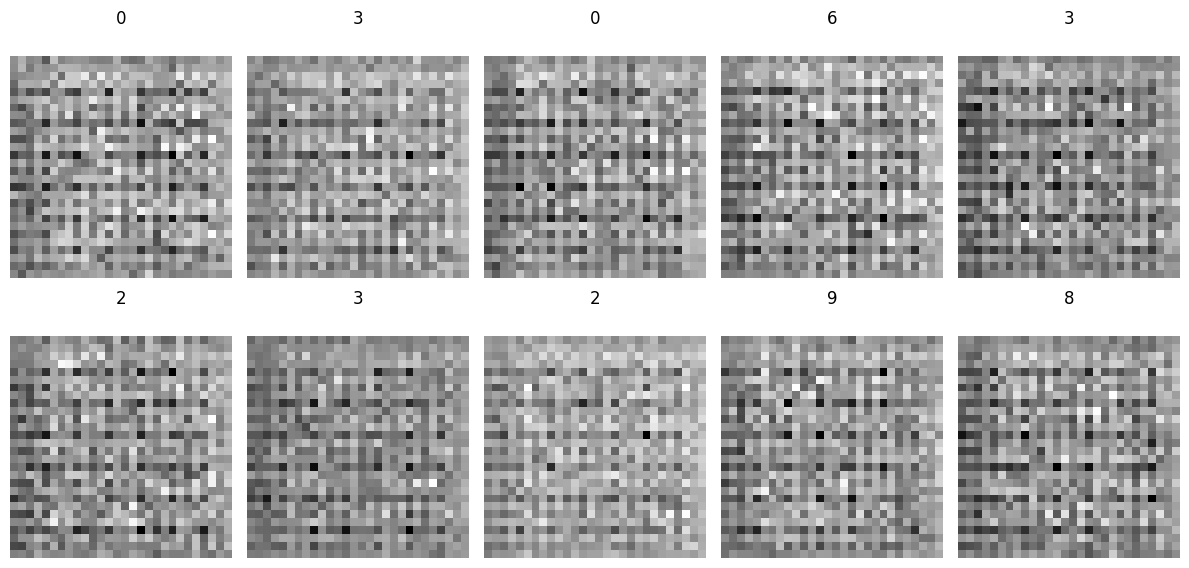

2/2 [==============================] - 0s 4ms/step
Epoch: 1, Batch: 201/468, D_Loss_Real=0.661, D_Loss_Fake=0.697 Gen_Loss=0.769
1/1 [==============================] - 0s 19ms/step


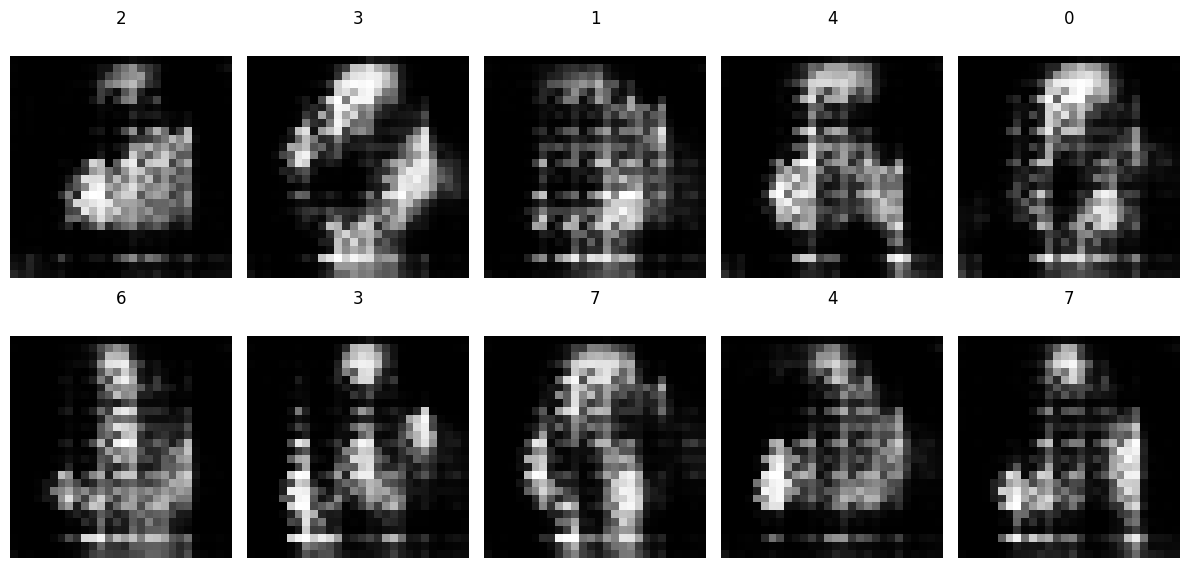

2/2 [==============================] - 0s 4ms/step
Epoch: 1, Batch: 401/468, D_Loss_Real=0.613, D_Loss_Fake=0.663 Gen_Loss=0.785
1/1 [==============================] - 0s 19ms/step


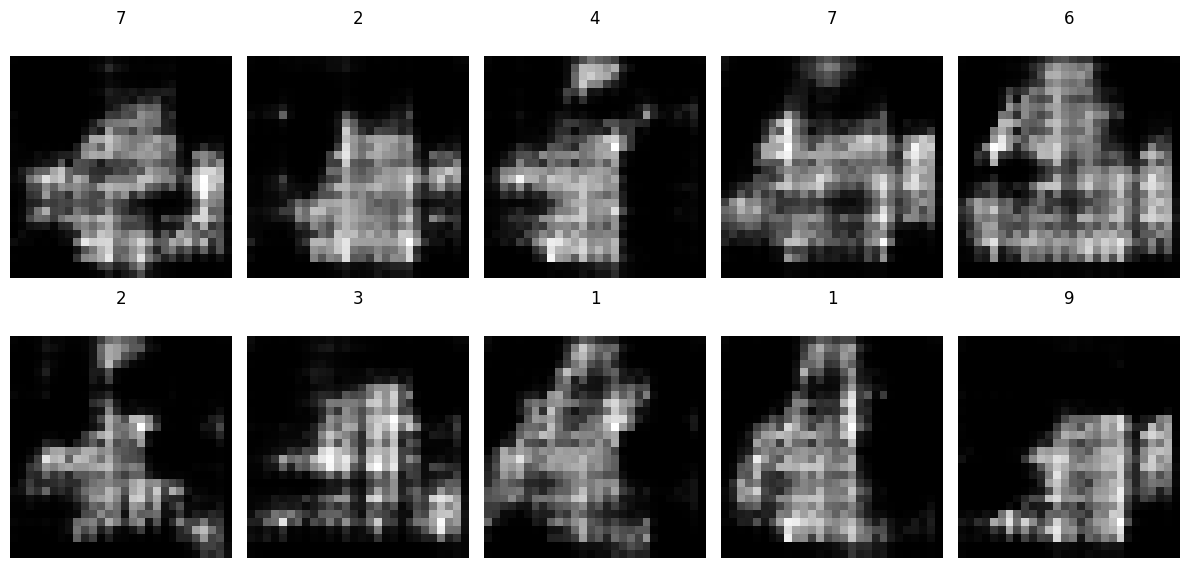

2/2 [==============================] - 0s 5ms/step
Epoch: 2, Batch: 1/468, D_Loss_Real=0.564, D_Loss_Fake=0.698 Gen_Loss=0.761
1/1 [==============================] - 0s 19ms/step


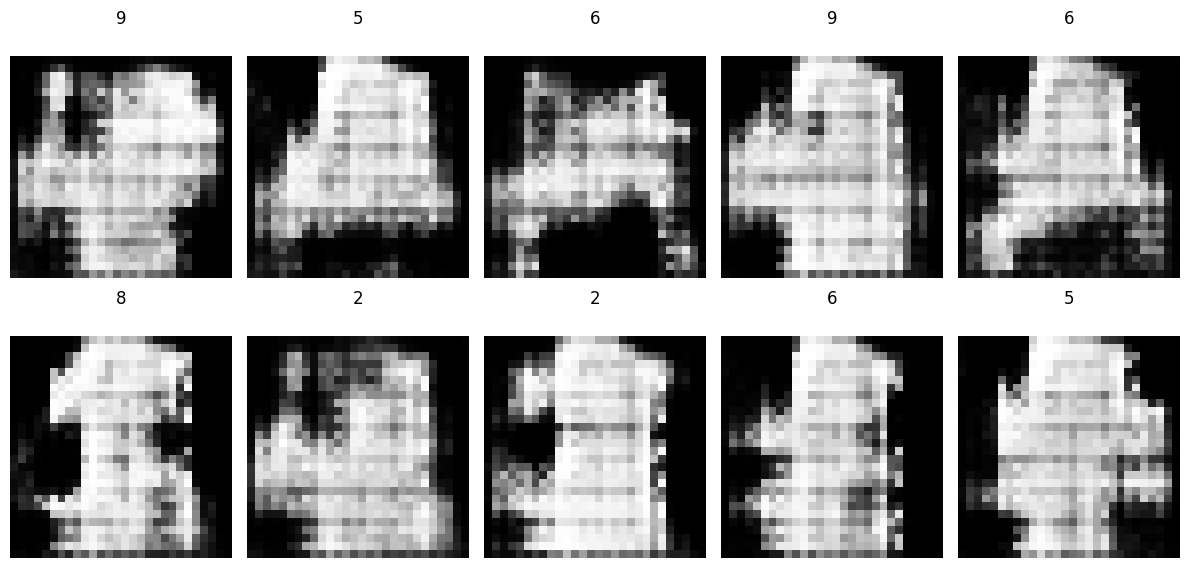

2/2 [==============================] - 0s 5ms/step
Epoch: 2, Batch: 201/468, D_Loss_Real=0.627, D_Loss_Fake=0.594 Gen_Loss=0.855
1/1 [==============================] - 0s 20ms/step


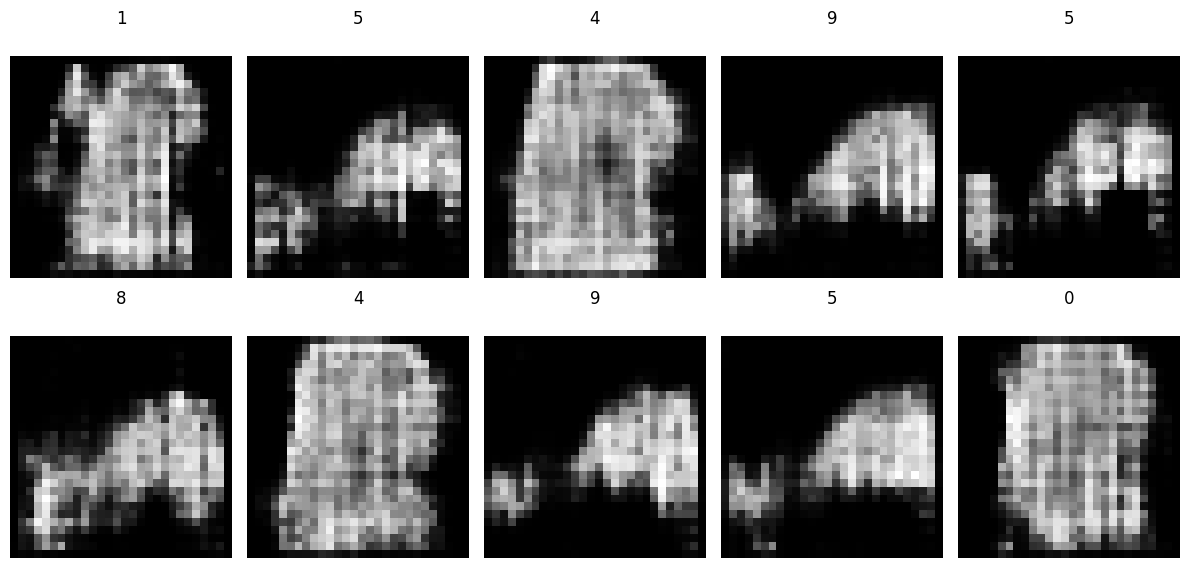

2/2 [==============================] - 0s 4ms/step
Epoch: 2, Batch: 401/468, D_Loss_Real=0.632, D_Loss_Fake=0.599 Gen_Loss=0.876
1/1 [==============================] - 0s 19ms/step


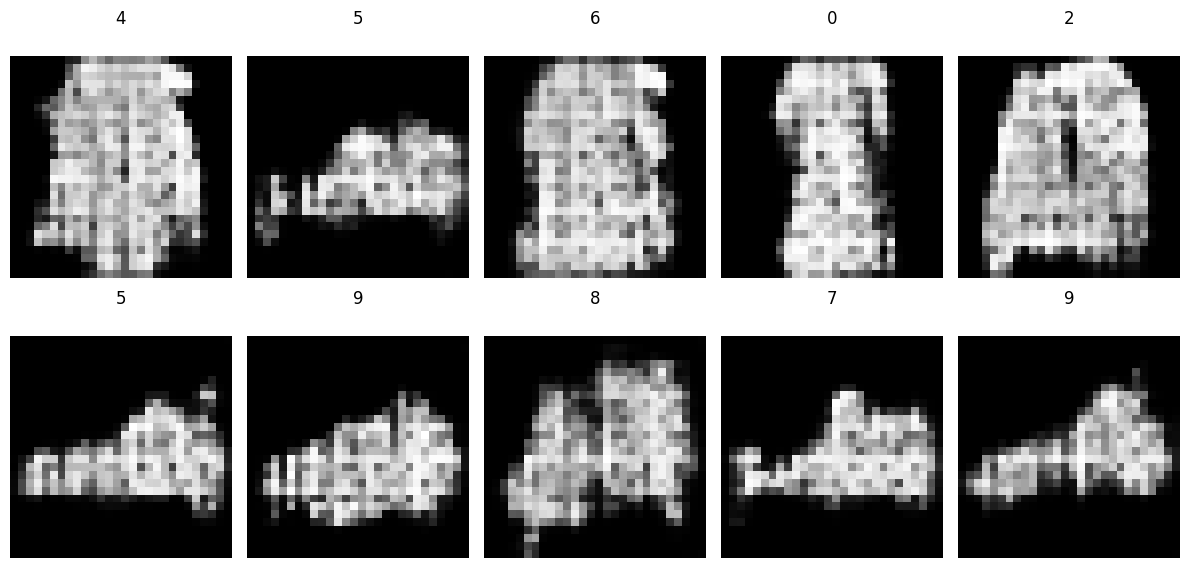

2/2 [==============================] - 0s 4ms/step
Epoch: 3, Batch: 1/468, D_Loss_Real=0.682, D_Loss_Fake=0.710 Gen_Loss=0.801
1/1 [==============================] - 0s 19ms/step


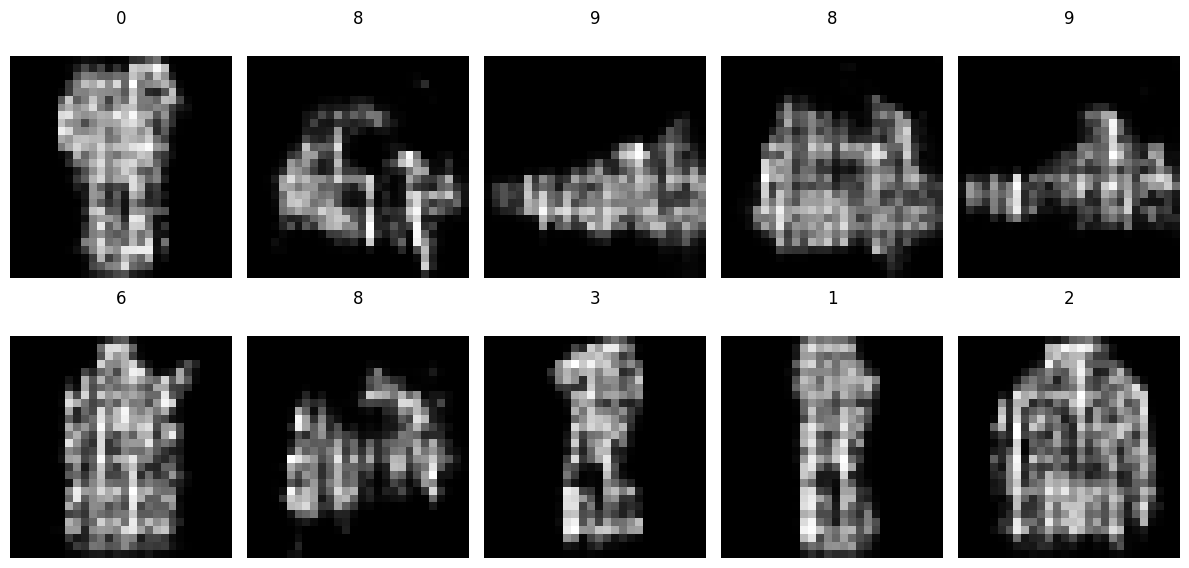

2/2 [==============================] - 0s 4ms/step
Epoch: 3, Batch: 201/468, D_Loss_Real=0.638, D_Loss_Fake=0.639 Gen_Loss=0.809
1/1 [==============================] - 0s 18ms/step


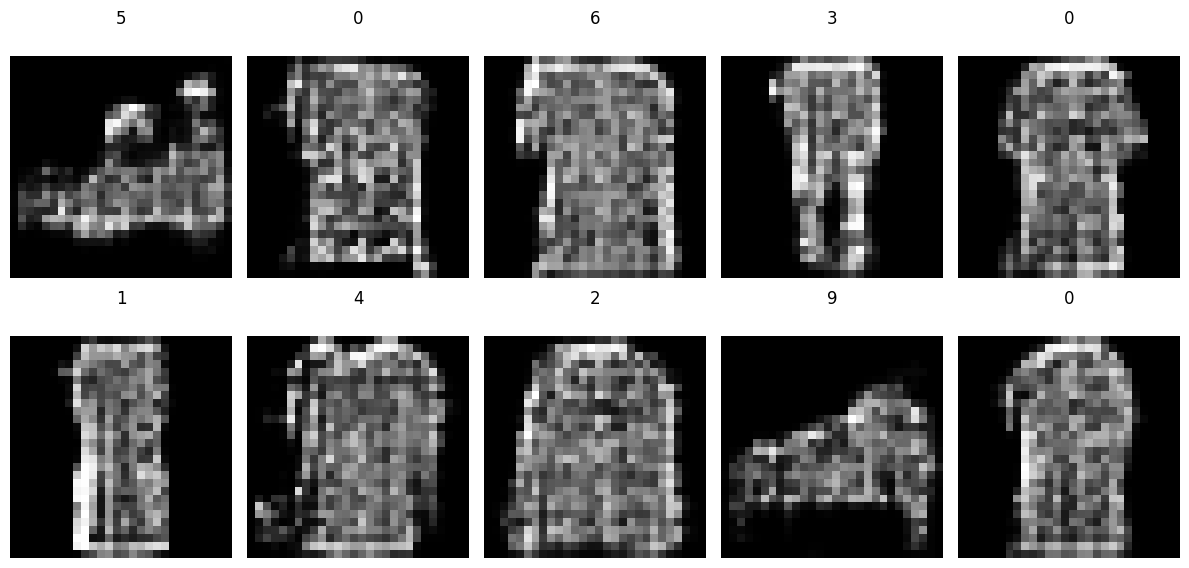

2/2 [==============================] - 0s 4ms/step
Epoch: 3, Batch: 401/468, D_Loss_Real=0.644, D_Loss_Fake=0.583 Gen_Loss=0.899
1/1 [==============================] - 0s 18ms/step


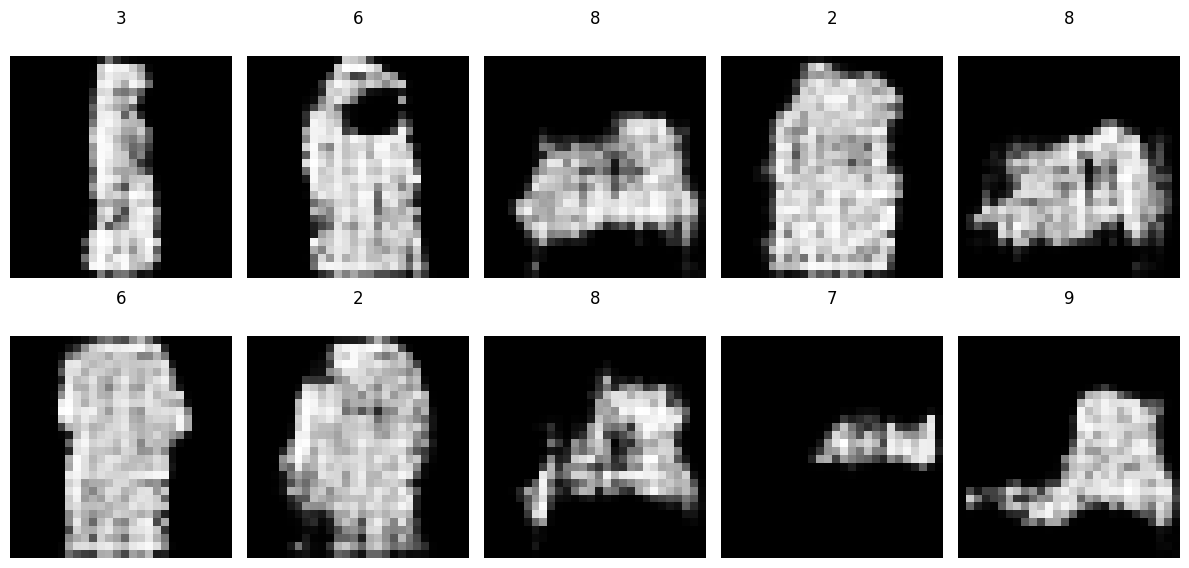

2/2 [==============================] - 0s 5ms/step
Epoch: 4, Batch: 1/468, D_Loss_Real=0.661, D_Loss_Fake=0.578 Gen_Loss=0.951
1/1 [==============================] - 0s 26ms/step


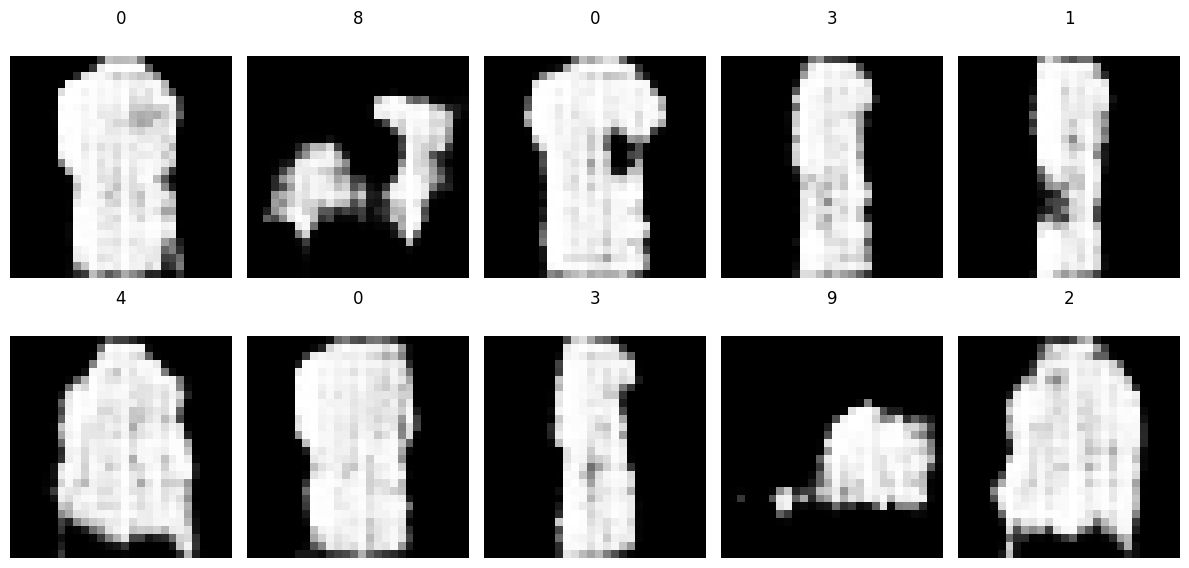

2/2 [==============================] - 0s 4ms/step
Epoch: 4, Batch: 201/468, D_Loss_Real=0.648, D_Loss_Fake=0.624 Gen_Loss=0.815
1/1 [==============================] - 0s 21ms/step


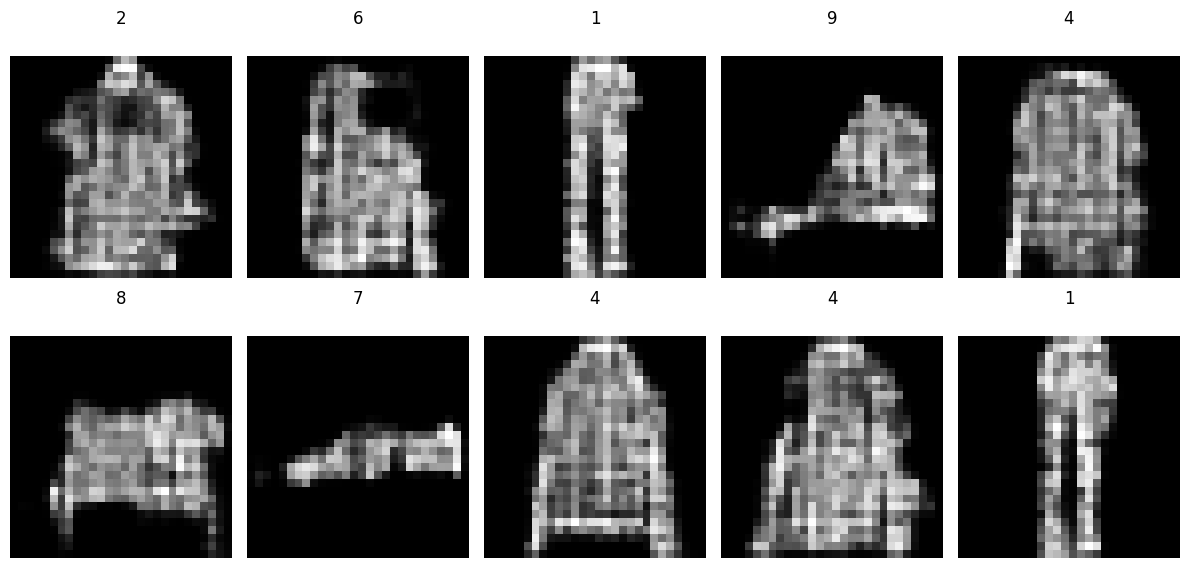

2/2 [==============================] - 0s 4ms/step
Epoch: 4, Batch: 401/468, D_Loss_Real=0.636, D_Loss_Fake=0.735 Gen_Loss=0.728
1/1 [==============================] - 0s 20ms/step


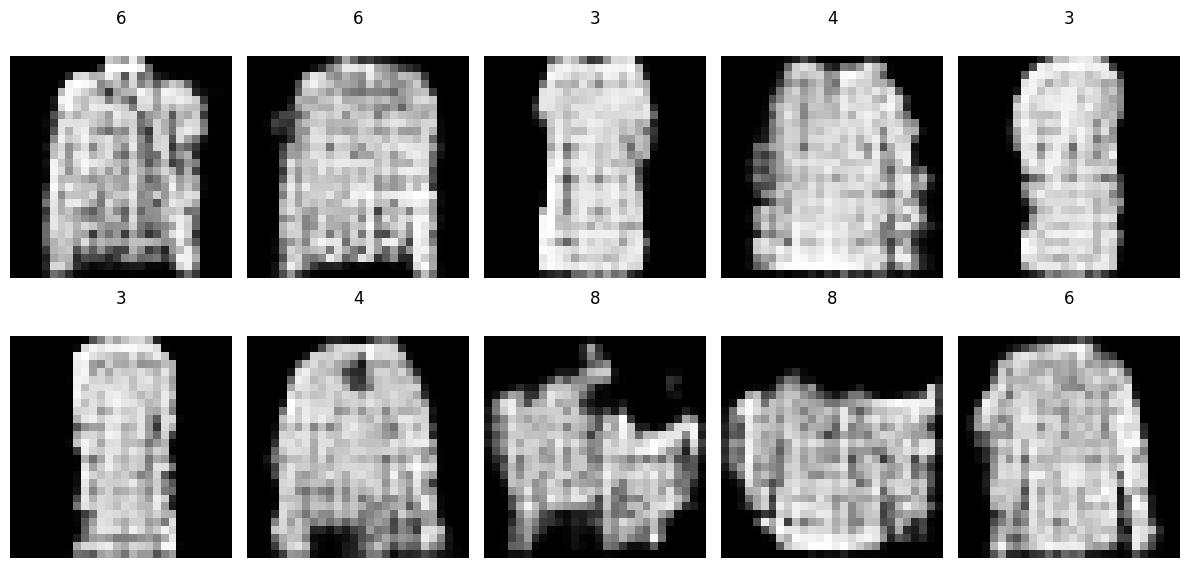

2/2 [==============================] - 0s 4ms/step
Epoch: 5, Batch: 1/468, D_Loss_Real=0.724, D_Loss_Fake=0.648 Gen_Loss=0.777
1/1 [==============================] - 0s 21ms/step


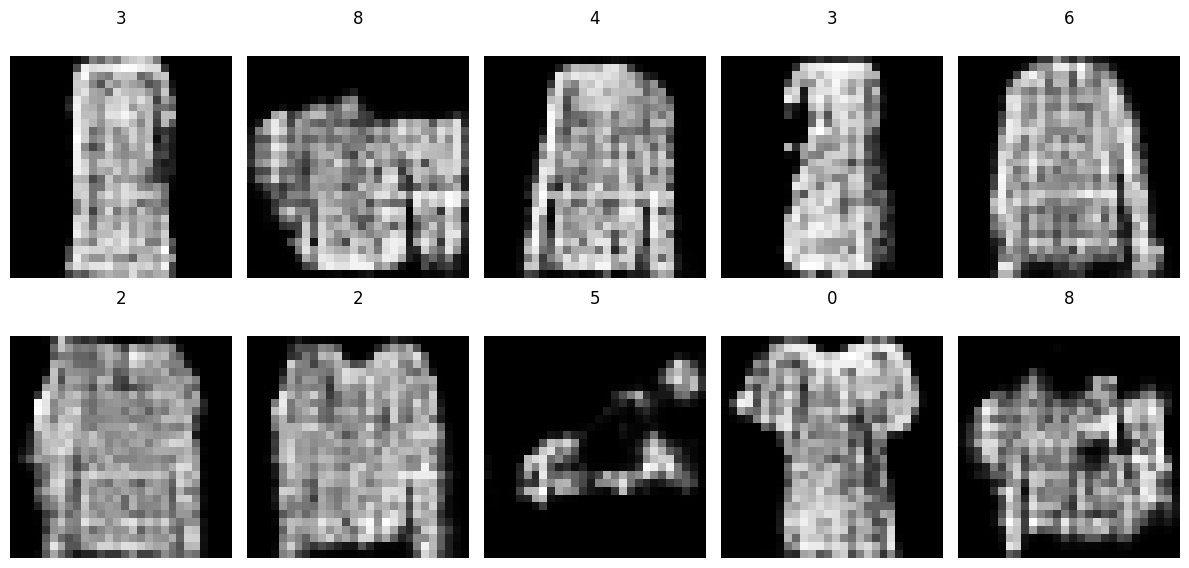

2/2 [==============================] - 0s 5ms/step
Epoch: 5, Batch: 201/468, D_Loss_Real=0.669, D_Loss_Fake=0.591 Gen_Loss=0.840
1/1 [==============================] - 0s 23ms/step


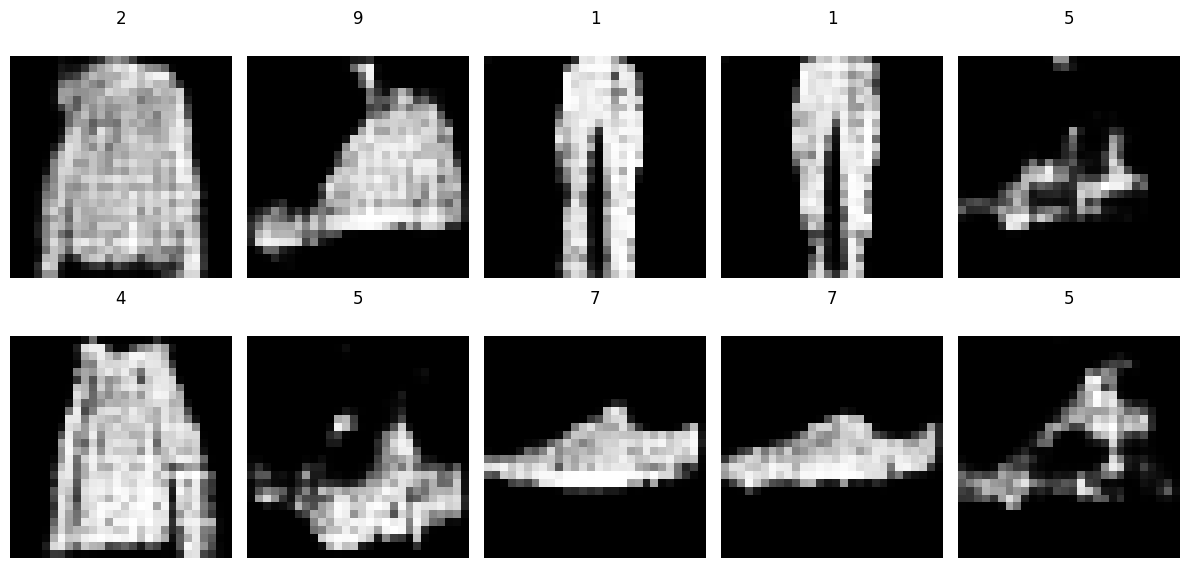

2/2 [==============================] - 0s 4ms/step
Epoch: 5, Batch: 401/468, D_Loss_Real=0.655, D_Loss_Fake=0.652 Gen_Loss=0.776
1/1 [==============================] - 0s 21ms/step


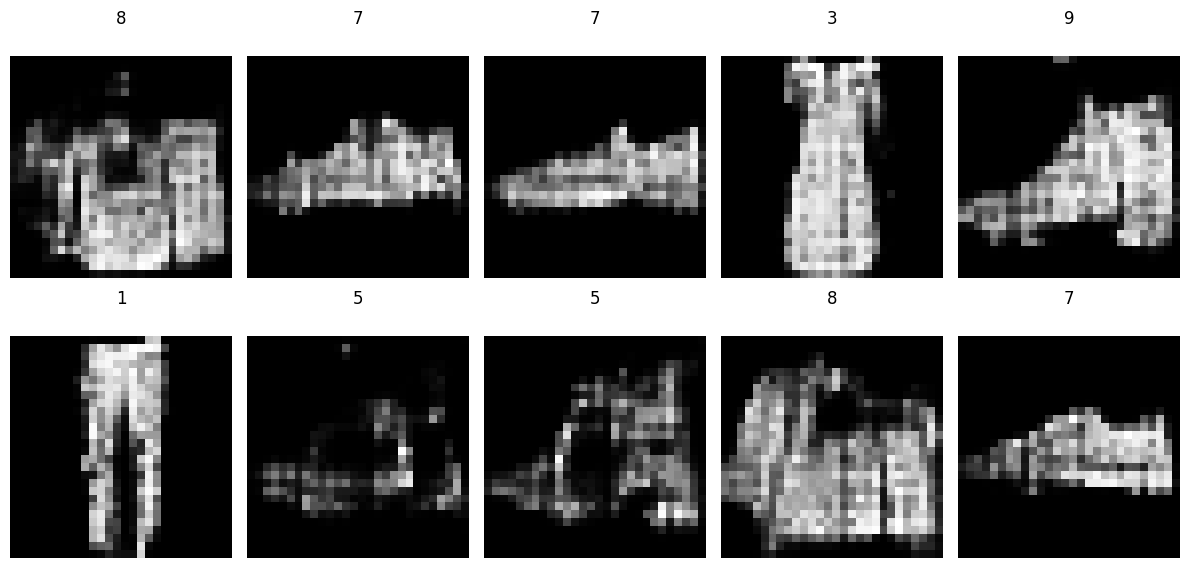

2/2 [==============================] - 0s 4ms/step
Epoch: 6, Batch: 1/468, D_Loss_Real=0.684, D_Loss_Fake=0.667 Gen_Loss=0.809
1/1 [==============================] - 0s 18ms/step


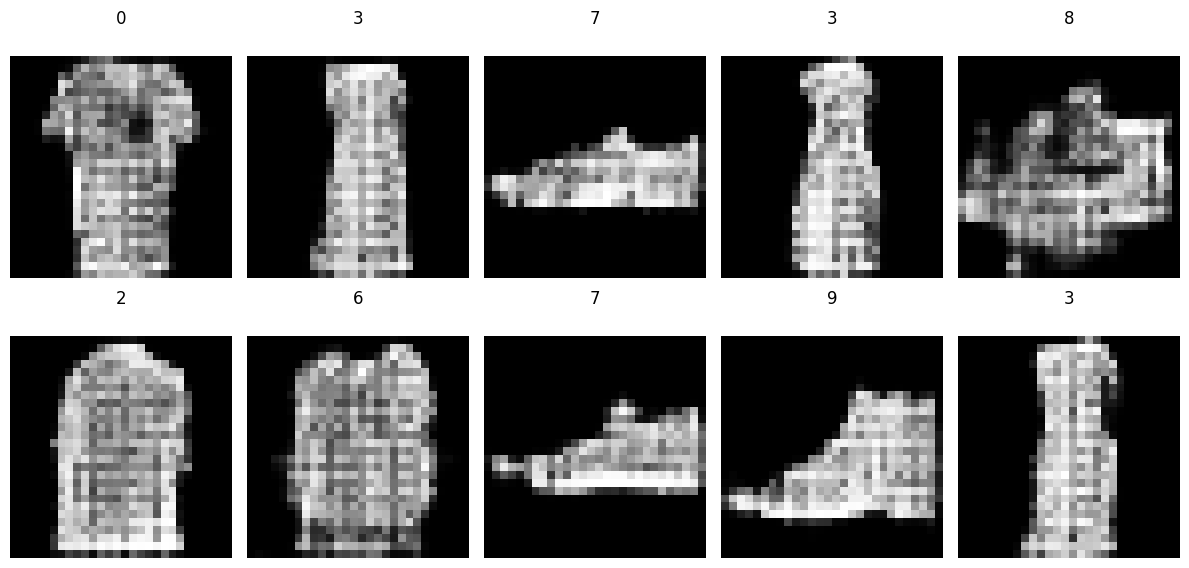

2/2 [==============================] - 0s 5ms/step
Epoch: 6, Batch: 201/468, D_Loss_Real=0.669, D_Loss_Fake=0.646 Gen_Loss=0.791
1/1 [==============================] - 0s 19ms/step


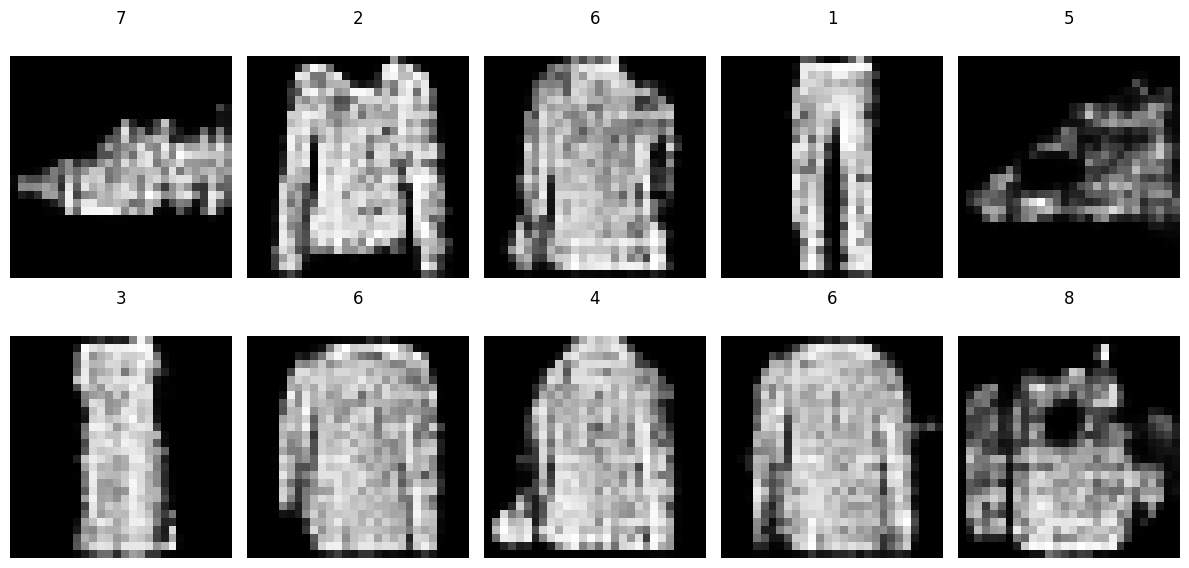

2/2 [==============================] - 0s 5ms/step
Epoch: 6, Batch: 401/468, D_Loss_Real=0.659, D_Loss_Fake=0.650 Gen_Loss=0.784
1/1 [==============================] - 0s 19ms/step


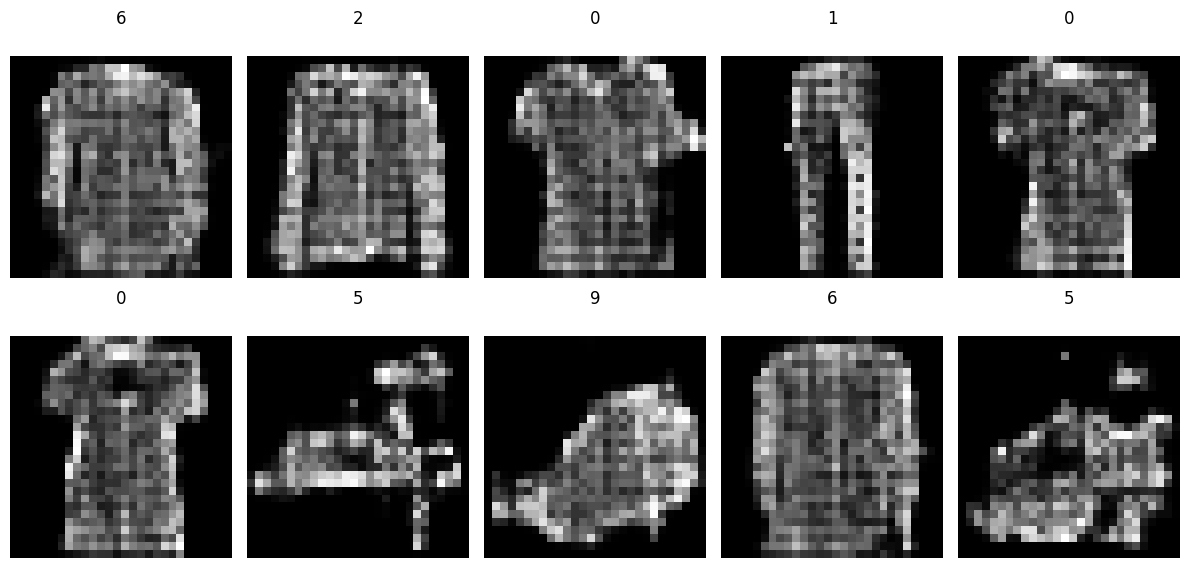

2/2 [==============================] - 0s 5ms/step
Epoch: 7, Batch: 1/468, D_Loss_Real=0.705, D_Loss_Fake=0.630 Gen_Loss=0.848
1/1 [==============================] - 0s 25ms/step


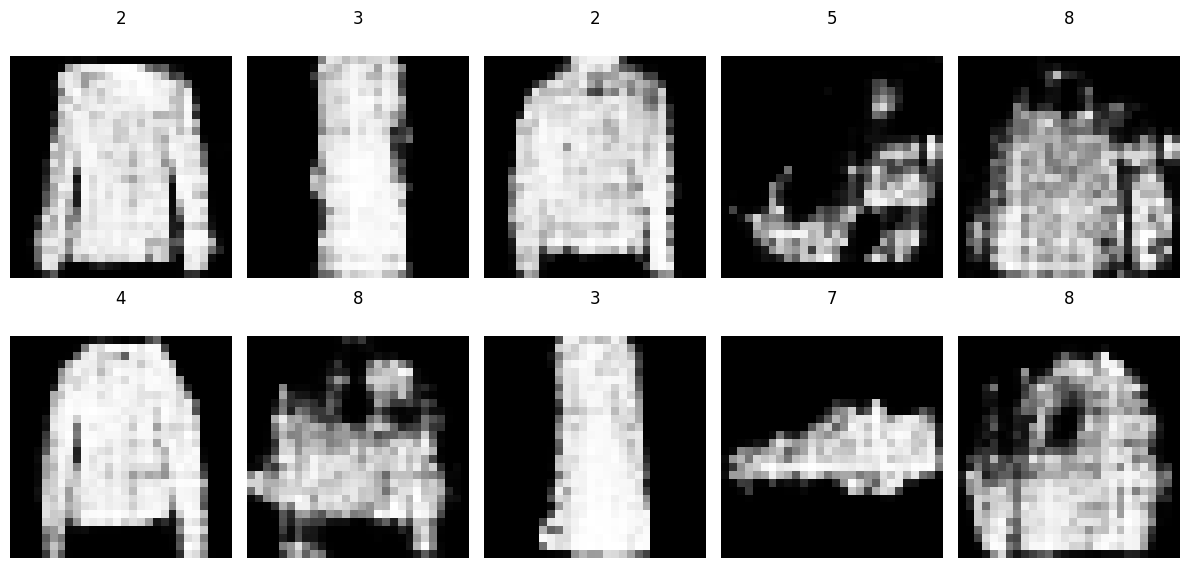

2/2 [==============================] - 0s 4ms/step
Epoch: 7, Batch: 201/468, D_Loss_Real=0.559, D_Loss_Fake=0.855 Gen_Loss=0.604
1/1 [==============================] - 0s 19ms/step


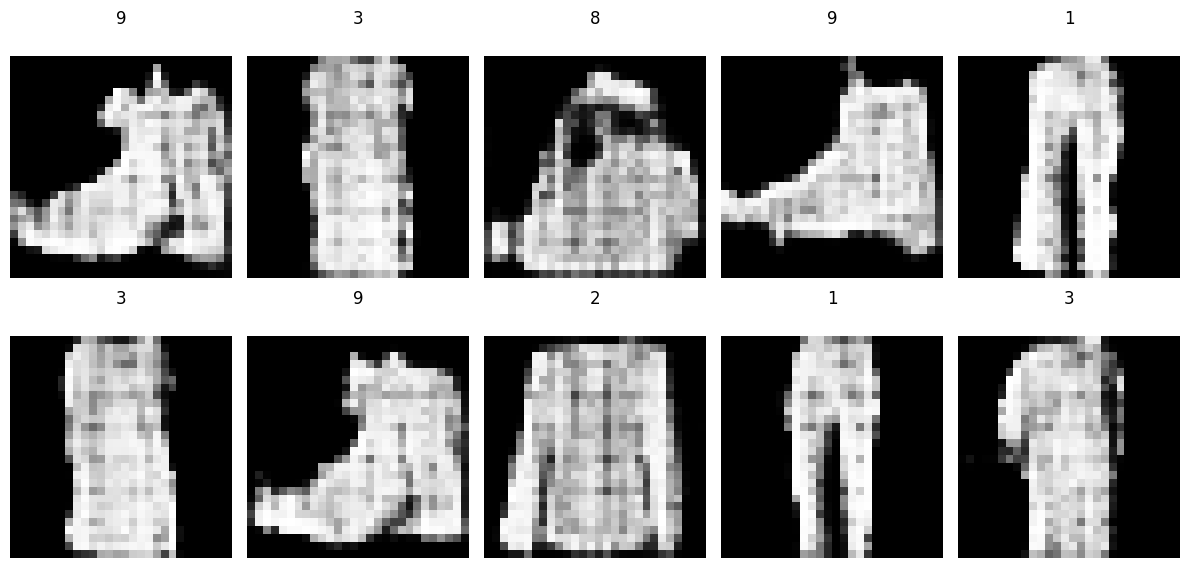

2/2 [==============================] - 0s 4ms/step
Epoch: 7, Batch: 401/468, D_Loss_Real=0.650, D_Loss_Fake=0.693 Gen_Loss=0.775
1/1 [==============================] - 0s 21ms/step


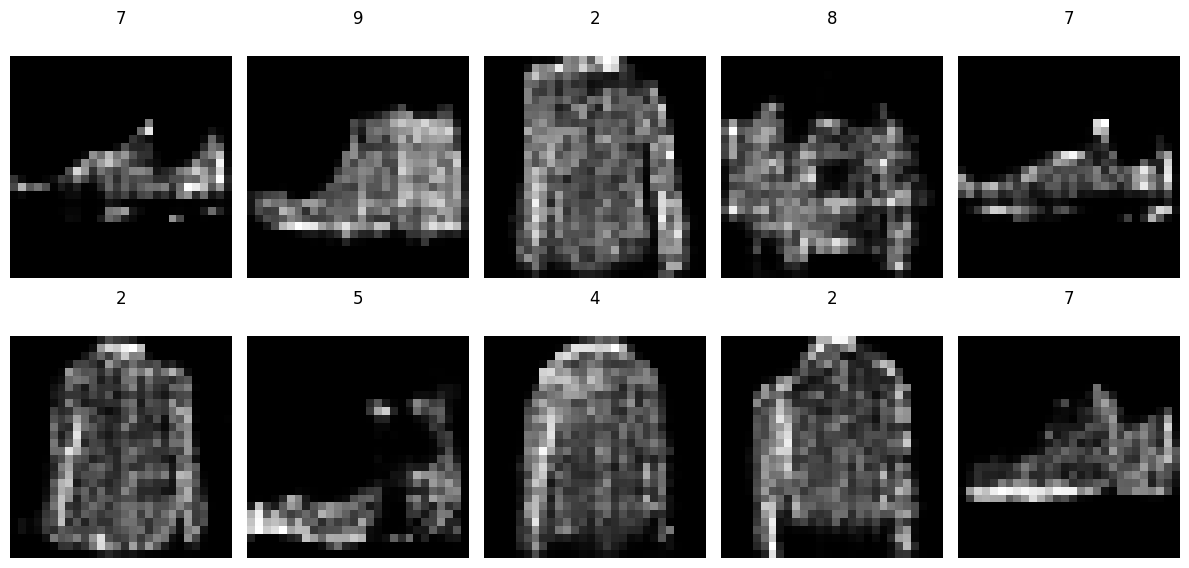

2/2 [==============================] - 0s 4ms/step
Epoch: 8, Batch: 1/468, D_Loss_Real=0.629, D_Loss_Fake=0.636 Gen_Loss=0.811
1/1 [==============================] - 0s 23ms/step


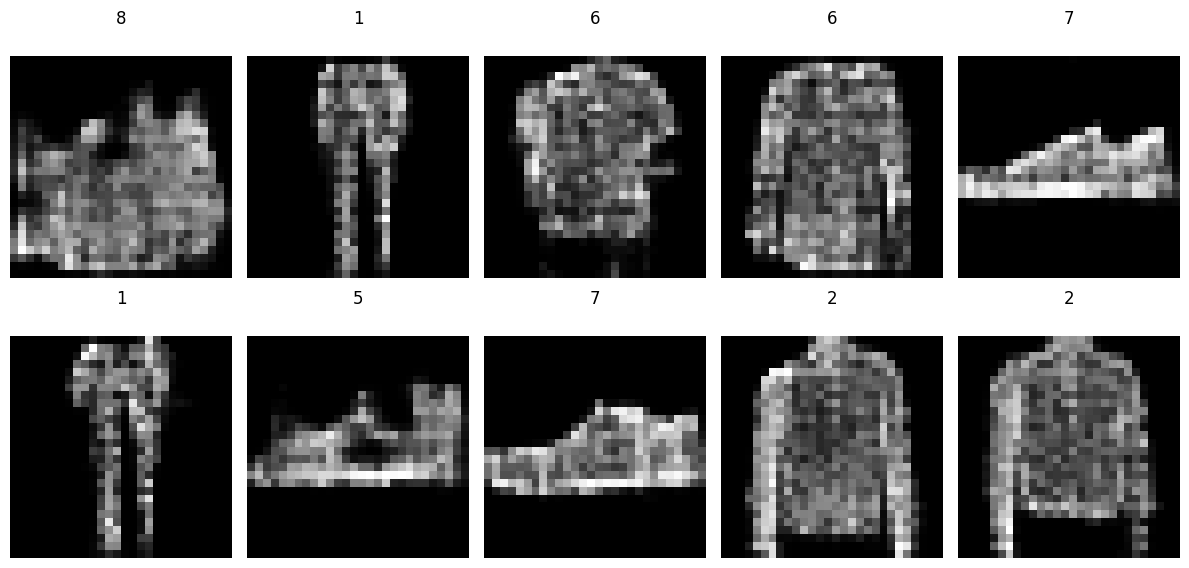

2/2 [==============================] - 0s 5ms/step
Epoch: 8, Batch: 201/468, D_Loss_Real=0.702, D_Loss_Fake=0.615 Gen_Loss=0.865
1/1 [==============================] - 0s 23ms/step


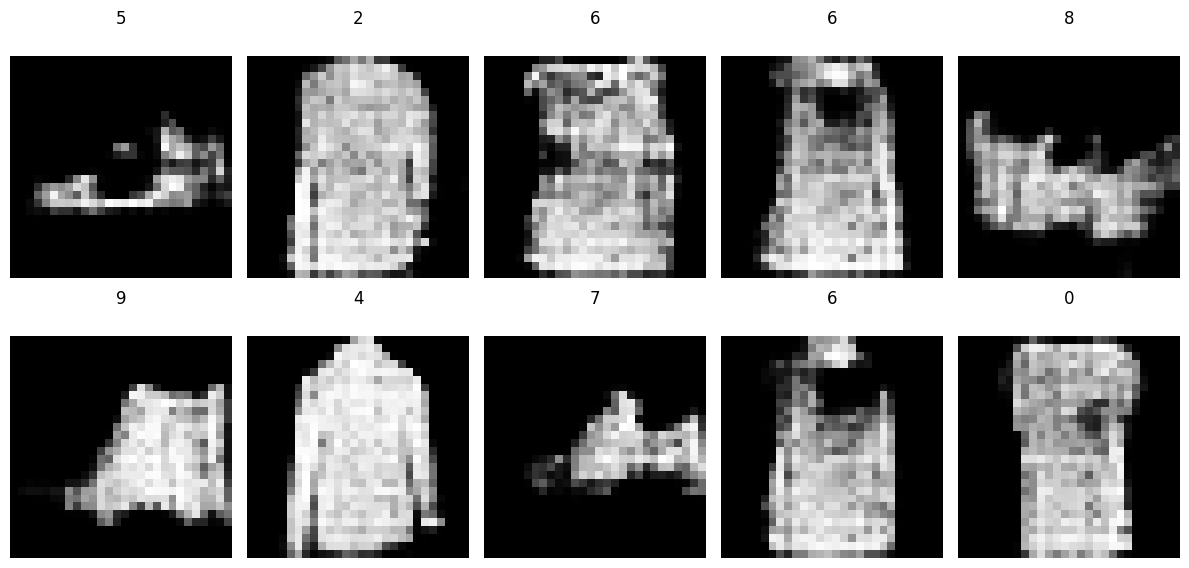

2/2 [==============================] - 0s 4ms/step
Epoch: 8, Batch: 401/468, D_Loss_Real=0.635, D_Loss_Fake=0.674 Gen_Loss=0.793
1/1 [==============================] - 0s 17ms/step


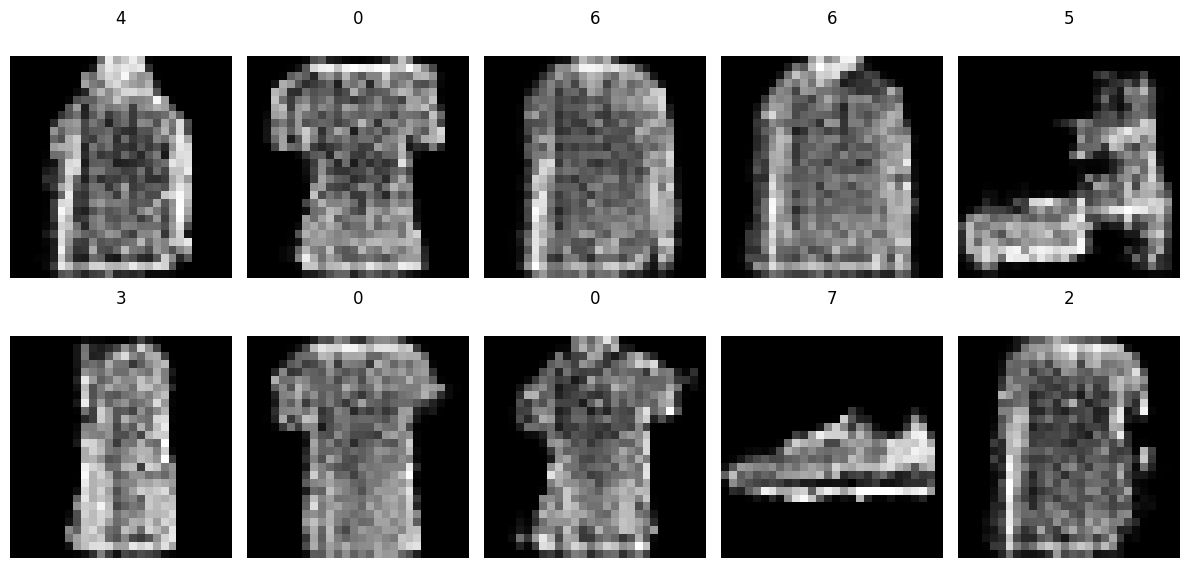

2/2 [==============================] - 0s 4ms/step
Epoch: 9, Batch: 1/468, D_Loss_Real=0.628, D_Loss_Fake=0.863 Gen_Loss=0.642
1/1 [==============================] - 0s 17ms/step


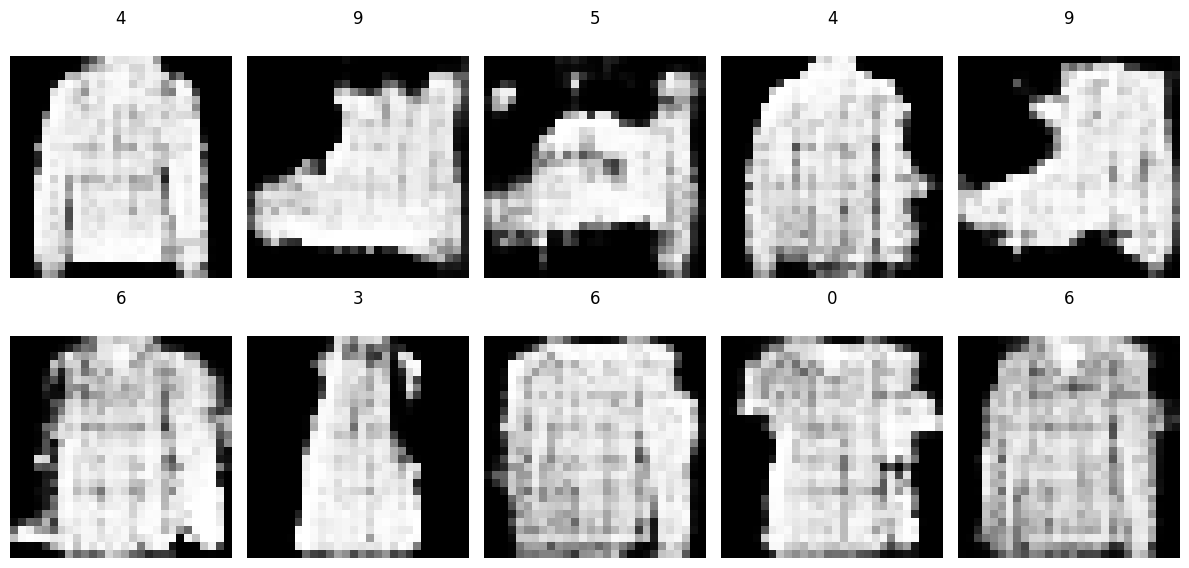

2/2 [==============================] - 0s 5ms/step
Epoch: 9, Batch: 201/468, D_Loss_Real=0.713, D_Loss_Fake=0.668 Gen_Loss=0.812
1/1 [==============================] - 0s 19ms/step


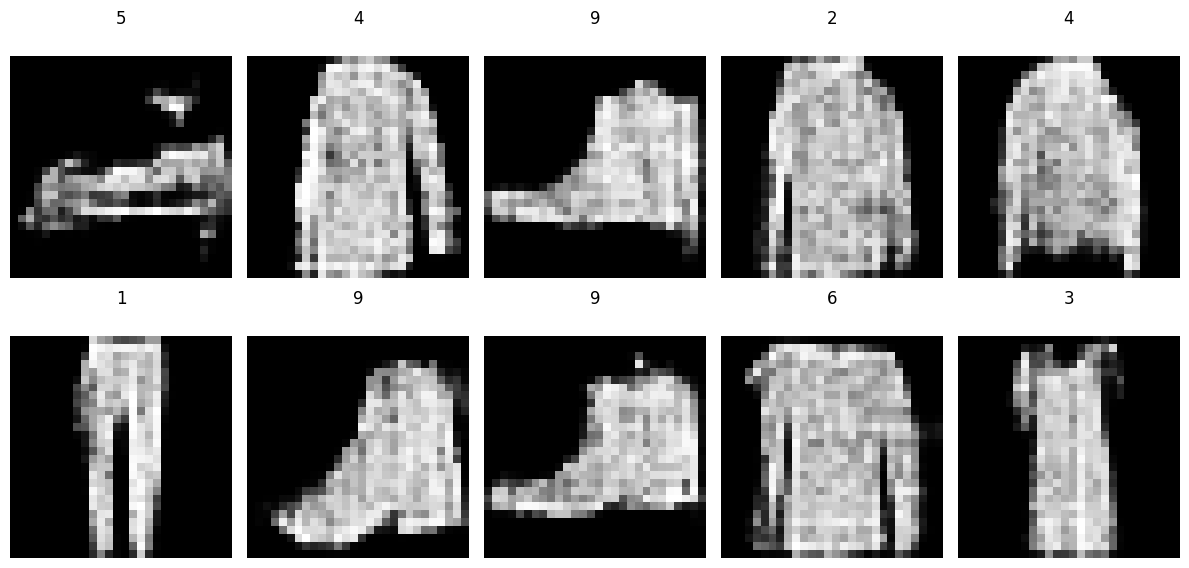

2/2 [==============================] - 0s 4ms/step
Epoch: 9, Batch: 401/468, D_Loss_Real=0.691, D_Loss_Fake=0.685 Gen_Loss=0.774
1/1 [==============================] - 0s 21ms/step


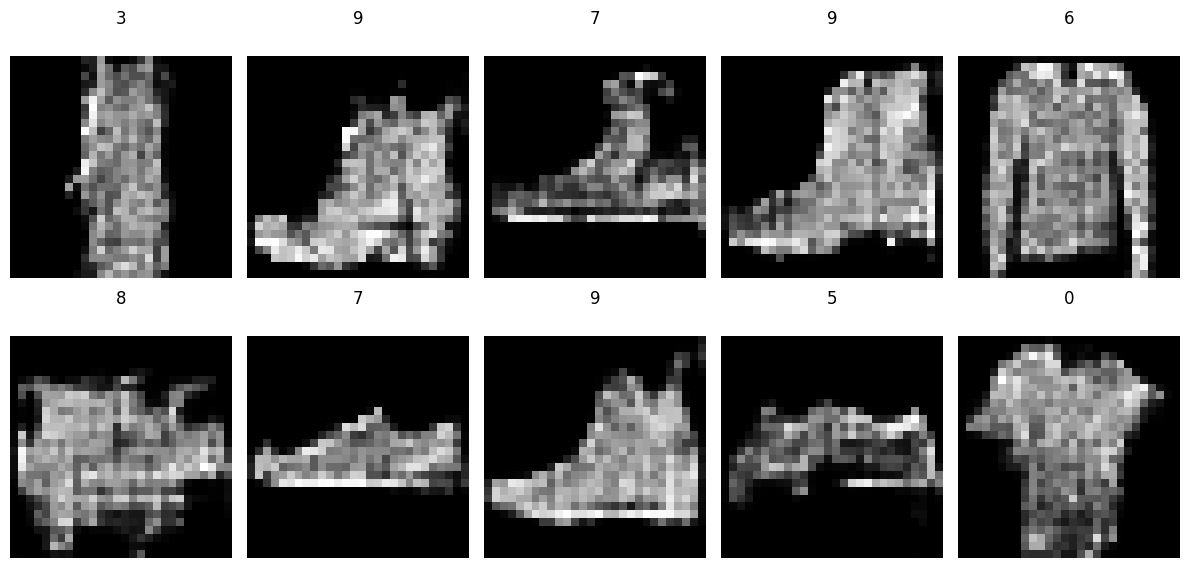

2/2 [==============================] - 0s 4ms/step
Epoch: 10, Batch: 1/468, D_Loss_Real=0.730, D_Loss_Fake=0.624 Gen_Loss=0.841
1/1 [==============================] - 0s 18ms/step


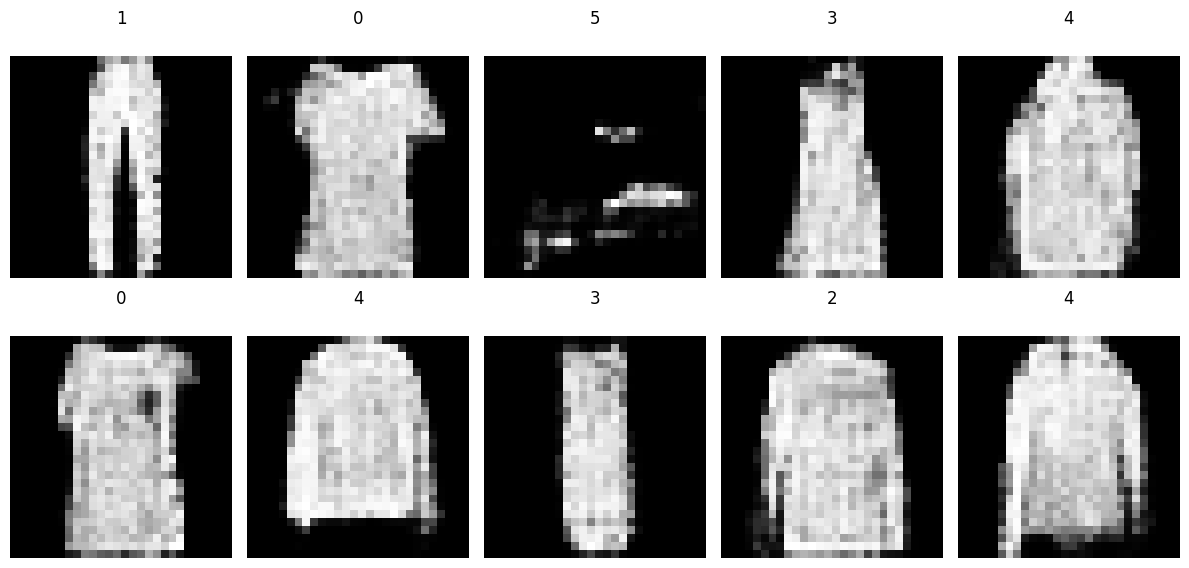

2/2 [==============================] - 0s 4ms/step
Epoch: 10, Batch: 201/468, D_Loss_Real=0.746, D_Loss_Fake=0.626 Gen_Loss=0.804
1/1 [==============================] - 0s 21ms/step


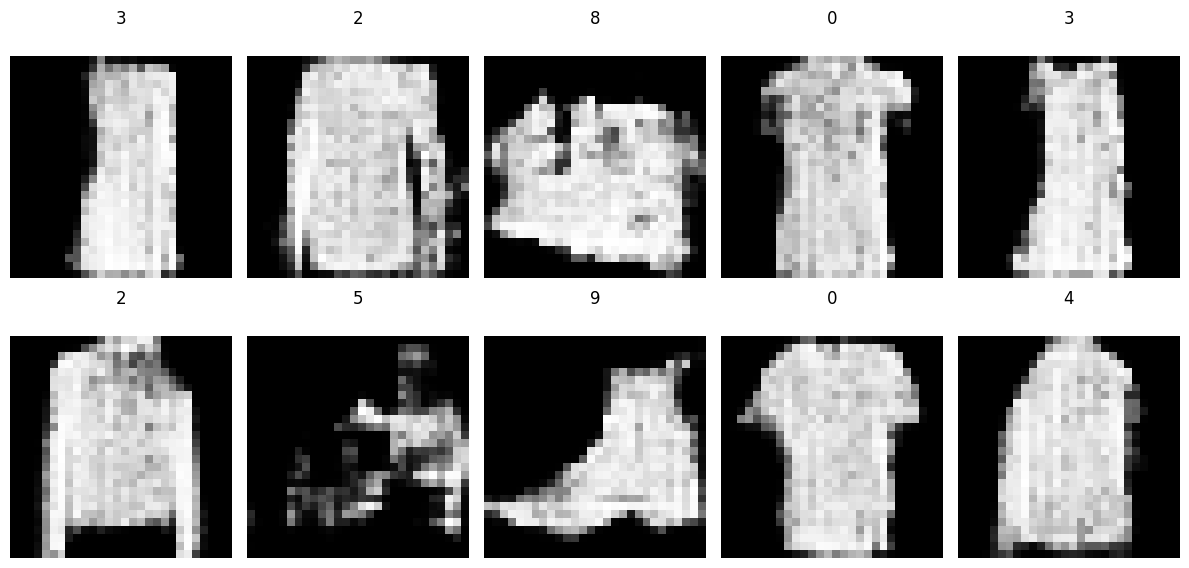

2/2 [==============================] - 0s 4ms/step
Epoch: 10, Batch: 401/468, D_Loss_Real=0.674, D_Loss_Fake=0.756 Gen_Loss=0.722
1/1 [==============================] - 0s 19ms/step


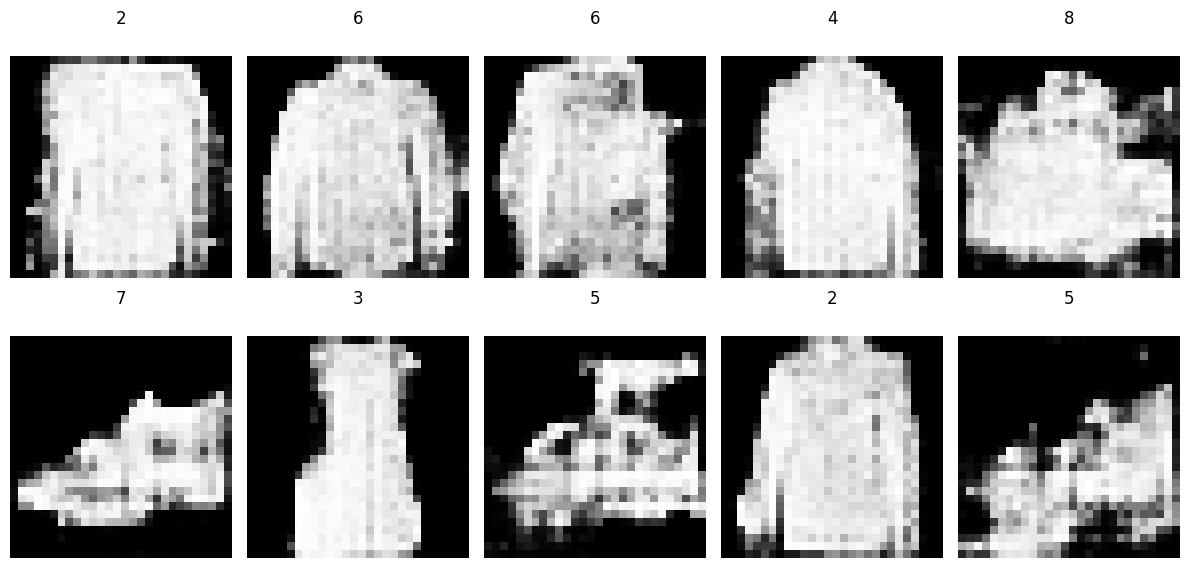

2/2 [==============================] - 0s 4ms/step


In [19]:
data=x_train.copy()
data=data.reshape(x_train.shape[0], 28, 28, 1)
n_epochs = 50
train(gen_model, dis_model, gan_model, data, y_train, latent_dim)

Una vez entenado el modelo, se puede guardar únicamente la parte del Generador para su uso futuro

In [20]:
gen_model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0002, beta_1=0.5))

### 5. Visualización de resultados

Por ultimo, se muestran algunas muestras de las imágenes generadas con esta CGAN (con la red generadora), tomando las etiquetas como input.Se van a generar 100 imágenes (10 de cada etiqueta)

1. Generación de vector latente asociado a etiquetas en concreto

In [21]:
latent_points, _ = latent_vector(100, 100)
labels = np.asarray([x for _ in range(10) for x in range(10)])

2. Carga del modelo y generación de imágenes

In [22]:
model = gen_model
gen_imgs  = model.predict([latent_points, labels])

4/4 [==============================] - 0s 93ms/step


3. Visualización de imágenes

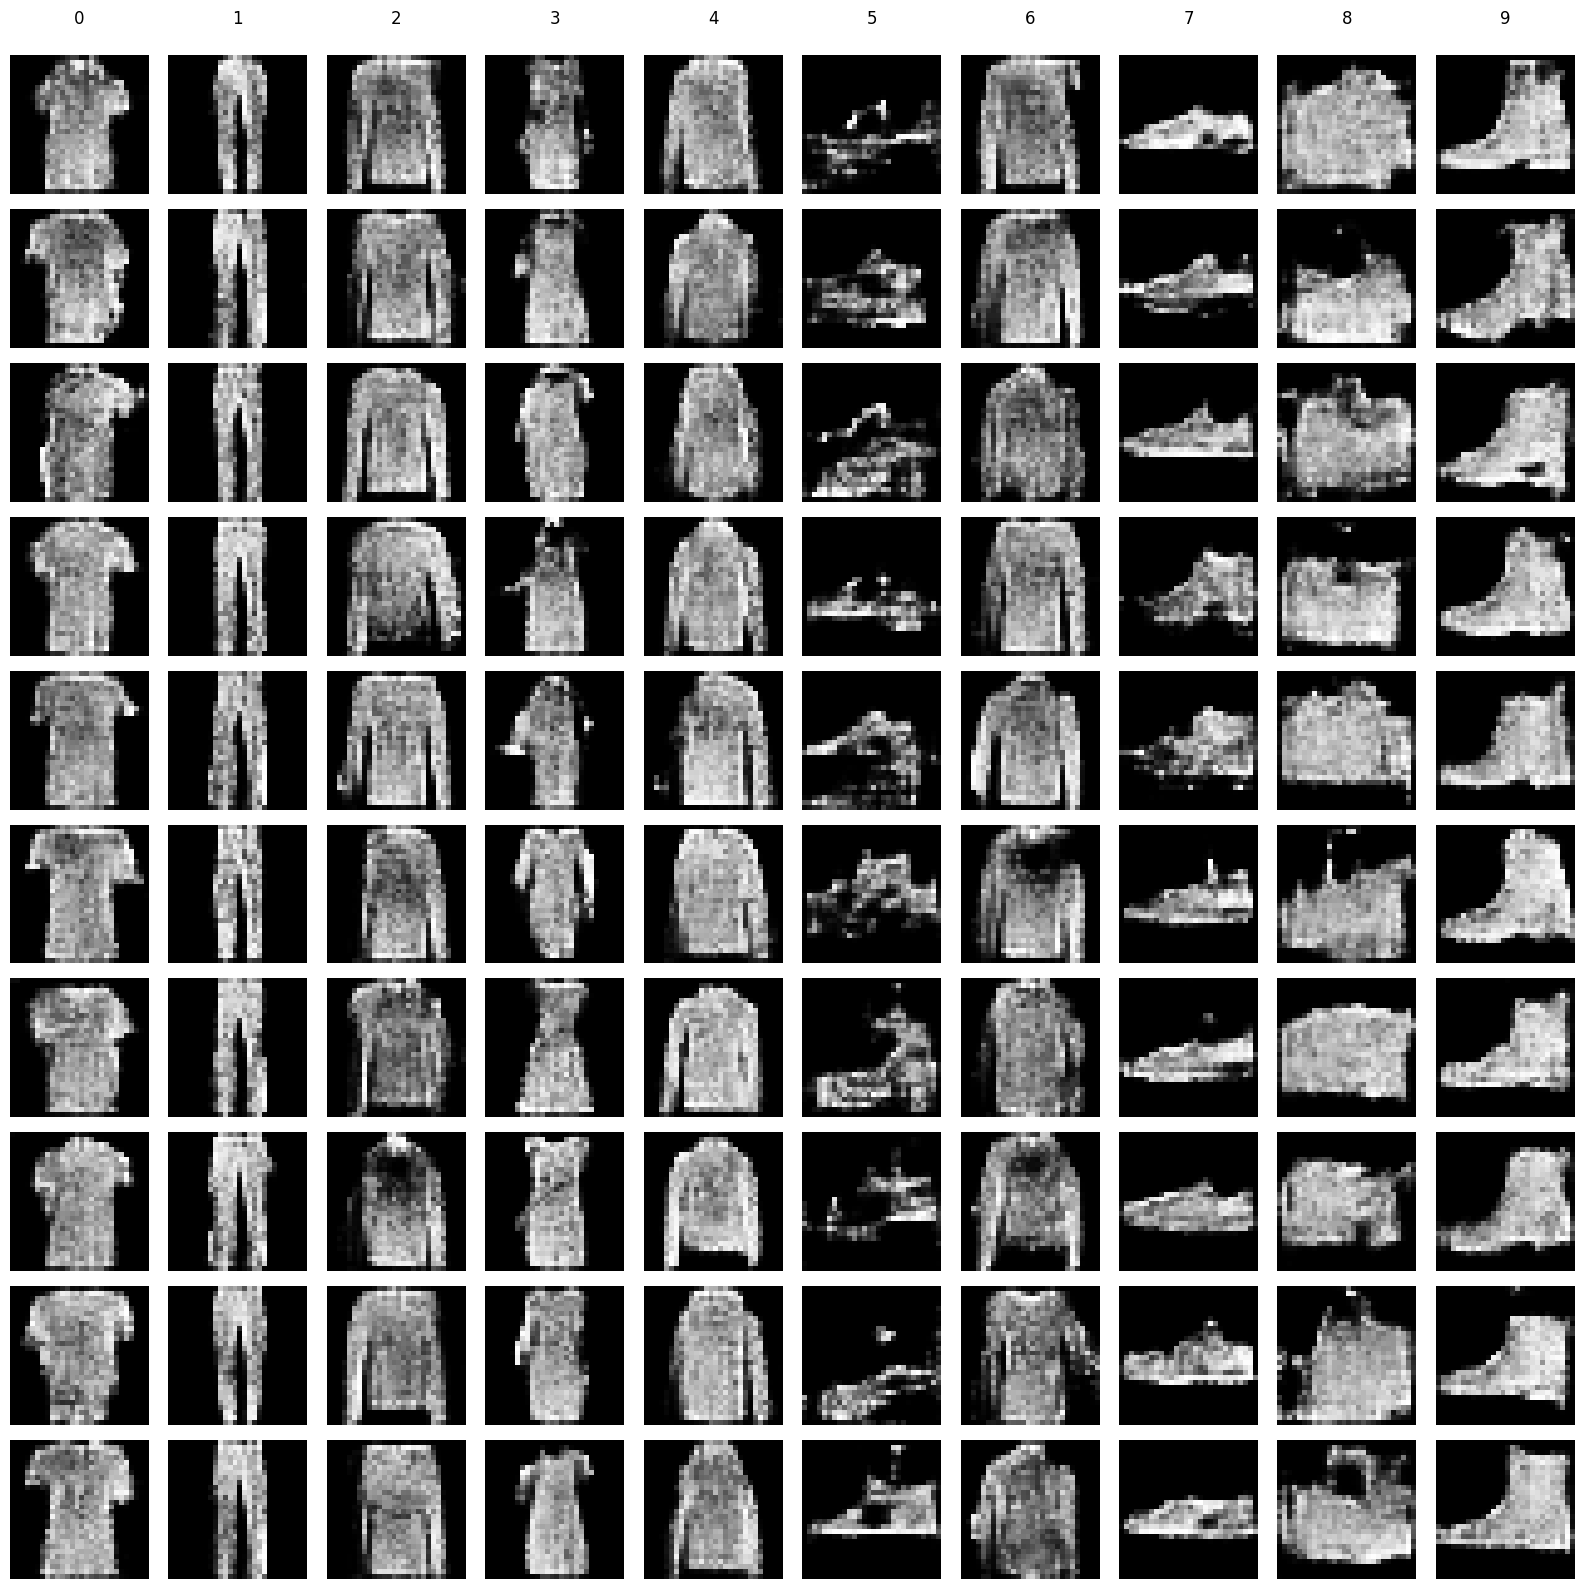

In [25]:
fig, axs = plt.subplots(10, 10, sharey=False, tight_layout=True, figsize=(16,16), facecolor='white')
k=0
for i in range(0,10):
    for j in range(0,10):
        axs[i,j].matshow(gen_imgs[k], cmap='gray')
        axs[0,j].set(title=labels[k])
        axs[i,j].axis('off')
        k=k+1
plt.show() 

Como se ha podido comprobar, sí que ha sido posible la generación de imágenes asociadas a etiquetas en concreto. No obstante, la calidad de las imágenes dista de ser igual de buena que las del dataset original. 

Algunas de las razones por las que la calidad podría ser mejorable son.

1. Dimensionalidad del espacio latente. La reducción de la dimensionalidad permite generar muestras más dispares, peron en las que se pierde mayor información (menor calidad de imagen). Se podría realiar una búsqueda iterativa para encontrar la dimensionalidad óptima del espacio latente.

2. Entrenamiento del modelo. El entrenamento de una GAN es un proceso tedioso y computacionalmente costoso (por lo menos para mi portátil). Un mayor enternamiento podría generar mejores imágenes (aunque seguiría limitado por la dimensionalidad del espacio latente)

3. Calidad de las imáganes originales. No hoy que olvidar que Fashion Mnist es un dataset de prueba, con ciertas limitaciones. La resolución de 28x28 píxeles por imágen hace que sea óptimo para entrenar modelos pequeños, y obtener buenos resultados rápidamente, pero limita la calidad de las imágenes generadas. Una mayor resolución del dataset original causaría un coste computacional mucho mayor, pero (si se consigue entrenar), generaría imágenes de mejor calidad.